In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
from source.read_HAR_dataset import DatasetHARUML20
from source.read_pamap2 import DatasetPAMAP2
from source.read_open_dataset import DatasetOpenDataset
from source.tserie import TSerie
from source.models.manifold.umap_fl import UMAP_FL
from sklearn import metrics
from xgboost import XGBClassifier
from source.utils import MetricsSaver, saveConfusionMatrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from source.utils import accuracy_per_class
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
datasetName = 'OpenDataset' # PAMAP2 or HAR-UML20 or OpenDataset
EXP_NAME = 'frequency_viz'
FEATURE_SIZE = 32
UMAP_NEIGHTBORS = 20
N_EPOCHS = 4000
RESULTS_PATH = 'results'
MODEL_NAME = 'UMAP'

In [6]:
if datasetName == 'PAMAP2':
    # signals=['handAcc16_1', 'handAcc16_2', 'handAcc16_3', 'handGyro1', 'handGyro2', 'handGyro3']
    signals=['heartrate']
    dataset = DatasetPAMAP2(seconds = 4 , mode = 'leave-one-subject')
    
elif datasetName ==  'HAR-UML20':
    signals = ['Accelerometer-X', 'Accelerometer-Y', 'Accelerometer-Z']
    dataset = DatasetHARUML20(mode = 'leave-one-subject')
    
elif datasetName == 'OpenDataset':
    # signals = ['accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'heart_rate ']
    signals = ['heart_rate']
    # signals = ['accelerometer_x', 'accelerometer_y', 'accelerometer_z']
    dataset = DatasetOpenDataset(mode = 'leave-one-subject')
    

    
CLASS_LABELS = dataset.activities
save_name = datasetName + '_' + EXP_NAME
saver = MetricsSaver(save_name, rows = ['train', 'test'], cols=['F1-score', 'Balanced Accuracy', 'Accuracy'])

In [7]:
n_ind = 0
all_res_df = None
predicted_classes = []
real_classes = []
while dataset.loadData():
    dataset.filterSignals(signals)
    
    ts_train = TSerie(dataset.X_train, dataset.Int_train, I=dataset.I_train)
    ts_test = TSerie(dataset.X_test, dataset.Int_test, I=dataset.I_test)
    
    ts_train.folding_features_v2()
    ts_test.folding_features_v2()
    
    model = UMAP_FL(n_components=32,n_neighbors=UMAP_NEIGHTBORS, n_epochs=N_EPOCHS, metric='euclidean')
    ts_train.features = model.fit_transform(ts_train.features)
    ts_test.features = model.transform(ts_test.features)




    # --------------------- Classify per intensity-------------------------


    clf = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
    clf.fit(ts_train.features, ts_train.y)
    train_pr = clf.predict(ts_train.features)
    test_pr = clf.predict(ts_test.features)
    
    # Add them to the global predictions
    predicted_classes.append(test_pr)
    real_classes.append(ts_test.y)


    # Save metrics
    train_f1 = metrics.f1_score(ts_train.y, train_pr, average='weighted')
    test_f1 = metrics.f1_score(ts_test.y, test_pr, average='weighted')
    train_bacc = metrics.balanced_accuracy_score(ts_train.y, train_pr)
    test_bacc = metrics.balanced_accuracy_score(ts_test.y, test_pr)
    train_acc = metrics.accuracy_score(ts_train.y, train_pr)
    test_acc = metrics.accuracy_score(ts_test.y, test_pr)

    saver.addLog('train', 'F1-score', train_f1)
    saver.addLog('test', 'F1-score', test_f1)
    saver.addLog('train', 'Balanced Accuracy', train_bacc)
    saver.addLog('test', 'Balanced Accuracy', test_bacc)
    saver.addLog('train', 'Accuracy', train_acc)
    saver.addLog('test', 'Accuracy', test_acc)



    # --------------------- Classify per activities-------------------------
    clf = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')

    train_bin_y = np.copy(ts_train.y)
    test_bin_y = np.copy(ts_test.y)

    target_intensity = 0

    train_bin_y[train_bin_y != target_intensity] = -1
    test_bin_y[test_bin_y != target_intensity] = -1
    train_bin_y[train_bin_y == target_intensity] = 1
    test_bin_y[test_bin_y == target_intensity] = 1
    train_bin_y[train_bin_y ==-1] = 0
    test_bin_y[test_bin_y ==-1] = 0


    if len(np.unique(dataset.y_test)) !=len(np.unique(dataset.y_train)):
        continue
    
    n_ind = n_ind + 1
    res_df = accuracy_per_class(
        clf, 
        train_bin_y, test_bin_y, 
        ts_train.features, ts_test.features, 
        dataset.y_train, dataset.y_test, 
        dataset.activities_map,
        is_binary=True,
    )
    
    if all_res_df is None:
        all_res_df = res_df
    else:
        all_res_df.loc[:, all_res_df.columns != 'classes'] = all_res_df.loc[:, all_res_df.columns != 'classes'] + res_df.loc[:, res_df.columns != 'classes']

all_res_df.loc[:, all_res_df.columns != 'classes'] = all_res_df.loc[:, all_res_df.columns != 'classes'] / n_ind

predicted_classes = np.concatenate(predicted_classes, axis = 0)
real_classes = np.concatenate(real_classes, axis = 0)

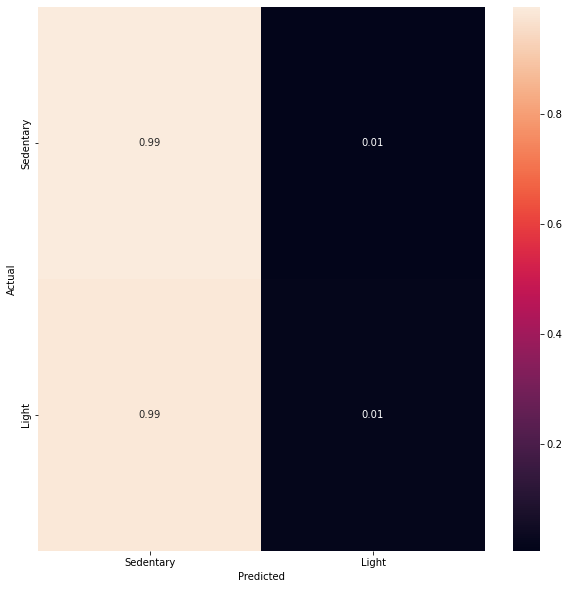

<Figure size 432x288 with 0 Axes>

In [8]:
saveConfusionMatrix(real_classes, predicted_classes, datasetName + '_PAI_{}'.format(MODEL_NAME), labels=dataset.intensities, xrotation=90)

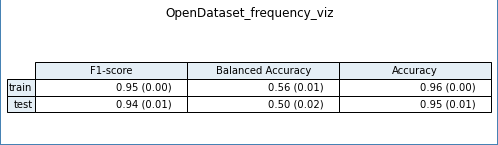

In [9]:
saver.toImage()

In [10]:
all_res_df

,classes,precision,recall,f1_score,accuracy,bal_accuracy
0,acostado-enreposo-cama;,1.0,1.000000,1.000000,1.000000,1.000000
1,acostado-enreposo-sofa;,1.0,0.992544,0.995820,0.992544,0.992544
2,acostado-usandotelefono-cama;,1.0,0.975769,0.986619,0.975769,0.975769
3,acostado-usandotelefono-sofa;,1.0,0.996368,0.998148,0.996368,0.996368
4,acostado-viendotelevision-sofa;,1.0,0.993476,0.996573,0.993476,0.993476
5,caminando;,0.0,0.000000,0.000000,0.013979,0.013979
6,parado;,1.0,0.968313,0.981087,0.968313,0.968313
7,reclinado-enreposo-cama;,1.0,1.000000,1.000000,1.000000,1.000000
8,reclinado-enreposo-escritorio;,1.0,0.993476,0.996397,0.993476,0.993476
9,reclinado-enreposo-sofa;,1.0,0.980429,0.988551,0.980429,0.980429
